In [1]:
# Importando dependências

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.tree import DecisionTreeRegressor  
import math
import os
! pip install patool
import patoolib

You should consider upgrading via the 'c:\users\felipe catapano\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
# Descomprimindo arquivo .rar e lendo o dataset
try:
    patoolib.extract_archive("vehicles.rar", outdir=os.getcwd())
    os.remove("vehicles.rar")
except:
    pass
Dataset = pd.read_csv('vehicles.csv')
Dataset = Dataset.iloc[28: , :]
Dataset.head(10)

patool: Extracting vehicles.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- "c:\Users\Felipe Catapano\Documents\GitHub\Car-Resell-Price-Predictor\vehicles.rar"
patool:     with cwd="c:\Users\Felipe Catapano\Documents\GitHub\Car-Resell-Price-Predictor"
patool: ... vehicles.rar extracted to `c:\Users\Felipe Catapano\Documents\GitHub\Car-Resell-Price-Predictor'.


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
28,7316814758,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,...,NaN,pickup,blue,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T12:31:08-0500
29,7316814989,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/01212_jjirIWa0y0...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T12:31:25-0500
30,7316743432,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00x0x_1y9kIOzGCF...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T10:41:31-0500
31,7316356412,https://auburn.craigslist.org/cto/d/auburn-uni...,auburn,https://auburn.craigslist.org,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,...,full-size,truck,black,https://images.craigslist.org/00404_l4loxHvdQe...,2013 F-150 XLT V6 4 Door. Good condition. Leve...,NaN,al,32.5920,-85.518900,2021-05-03T14:02:03-0500
32,7316343444,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,...,NaN,pickup,black,https://images.craigslist.org/00V0V_ftJbKrOgdi...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T13:41:25-0500
33,7316304717,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,...,NaN,pickup,silver,https://images.craigslist.org/00E0E_iKN07Sh7ou...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T12:41:33-0500
34,7316285779,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,35000,2019.0,toyota,tacoma,excellent,6 cylinders,...,NaN,truck,grey,https://images.craigslist.org/00101_dXoZTH7iVm...,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,NaN,al,32.6013,-85.443974,2021-05-03T12:12:59-0500
35,7316257769,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T11:31:14-0500
36,7316133914,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,38590,2011.0,chevrolet,corvette grand sport,good,8 cylinders,...,NaN,other,red,https://images.craigslist.org/00U0U_kKYnS1LWh8...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T07:50:35-0500
37,7316130053,https://auburn.craigslist.org/cto/d/opelika-19...,auburn,https://auburn.craigslist.org,4500,1992.0,jeep,cherokee,excellent,6 cylinders,...,NaN,NaN,NaN,https://images.craigslist.org/01010_7EM2aot64G...,192k miles brand new TSLs 4x4 jeep xj. 4x4 wor...,NaN,al,32.6454,-85.378300,2021-05-03T07:38:05-0500


# Quanto vale seu carro usado no Craigslist?

### A partir da análise de Dataset, ano do modelo, estado de conservação, tipo de combustível, entre outros, pretendemos prever o preço de revenda de um carro na plataforma Craigslist.

O mercado de carros usados sempre foi muito ativo em todas as partes do mundo. No entanto, diferente da compra de carros novos na qual há uma entidade respeitada por trás da venda (uma concessionária), no caso de carros usados essas compras e vendas podem ser feitas sem intermédio de uma concessionária. Isso abre espaço para dúvidas em relação a valor de um veículo uma vez que não há um estudo feito por profissionais de uma concessionária. Para ajudar com isso, um preditor de valores de carros usados vendidos na internet é útil para auxiliar o comprador (e o vendedor) a entender quais as tendências e médias de preço do carro de interesse.

In [3]:
# Remoção de outliers: Removeremos todas as linhas que tenham um preço com Z score(Número de desvios padrão
# de distância da média) maior ou igual a 3

z_scores = stats.zscore(Dataset.price)
abs_z = np.abs(z_scores)
Dataset['sigma'] = abs_z

Dataset = Dataset.loc[Dataset.sigma < 3,:]



# Descrição do Dataset

### O dataset utilizado para treinar o regressor foi retirado do Kaggle. É uma base de dados de carros usados vendidos no site Craigslist que contém 26 colunas (variáveis distintas) e mais de 400 mil linhas (carros catalogados). Dentro dessas 26 variáveis há desde URLs dos anúncios, a especificações mecânicas e de estado do veículo, até local do anúncio. Para o regressor os primeiros e últimos não são interessantes para prever o preço dos carros pois não influenciam em seus valores de venda.
Para treinar o regressor foram utilizadas as características que dizem respeito ao veículo em si como variáveis feature. Foram escolhidas: ano, estado do carro (inteiro, em peças, reconstruído etc), condição, tipo de câmbio, número de cilindros, tipo de combustível, carroceria, cor da pintura, montadora, tração e tamanho. Apenas com esses inputs o objetivo é prever o preço dos carros com uma margem de erro de 10% do preço catalogado. 
Naturalmente os valores que cada variável pode assumir no dataset não são todos os que elas poderiam assumir na vida real, a exemplo: as trações podem assumir os valores “4wd” (4x4), “fwd” (tração dianteira) ou “rwd” (tração traseira); nota-se que não existe o valor “awd” (tração integral) embora esse tipo de tração seja longe de ser incomum em carros de rua. Mesmo assim, a base de dados foi considerada bastante sólida pela quantidade e variedade de valores que as variáveis feature assumem.

# Análise exploratória -- Preços

Preço é a variável target do modelo. Assim, é de interesse analisar quais são os fatores fundamentais que influenciam em seu valor. Nesse sentido, através de gráficos de dispersão, histogramas e outras ferramentas estatísticas, determinaremos as features a serem consideradas.

In [21]:
#Criando função que facilita a plotagem de vários

def PlotVariosHist(bins, target, unidade_target, feature, feature_string, valores, color):
    plt.figure(figsize=(20,30))
    for valor in valores:
        plt.subplot(321+valores.index(valor))
        plt.hist(Dataset.loc[feature == valor][target], bins, edgecolor='white',density=True, color=color)
        plt.title("Densidade da frequência de {} quando {} é {}".format(target, feature_string, valor))
        plt.xlabel("{}, em {}".format(target, unidade_target))
        plt.ylabel("Densidade")
    plt.show()

clean         0.965382
rebuilt       0.018486
salvage       0.009933
lien          0.003677
missing       0.002035
parts only    0.000487
Name: title_status, dtype: float64


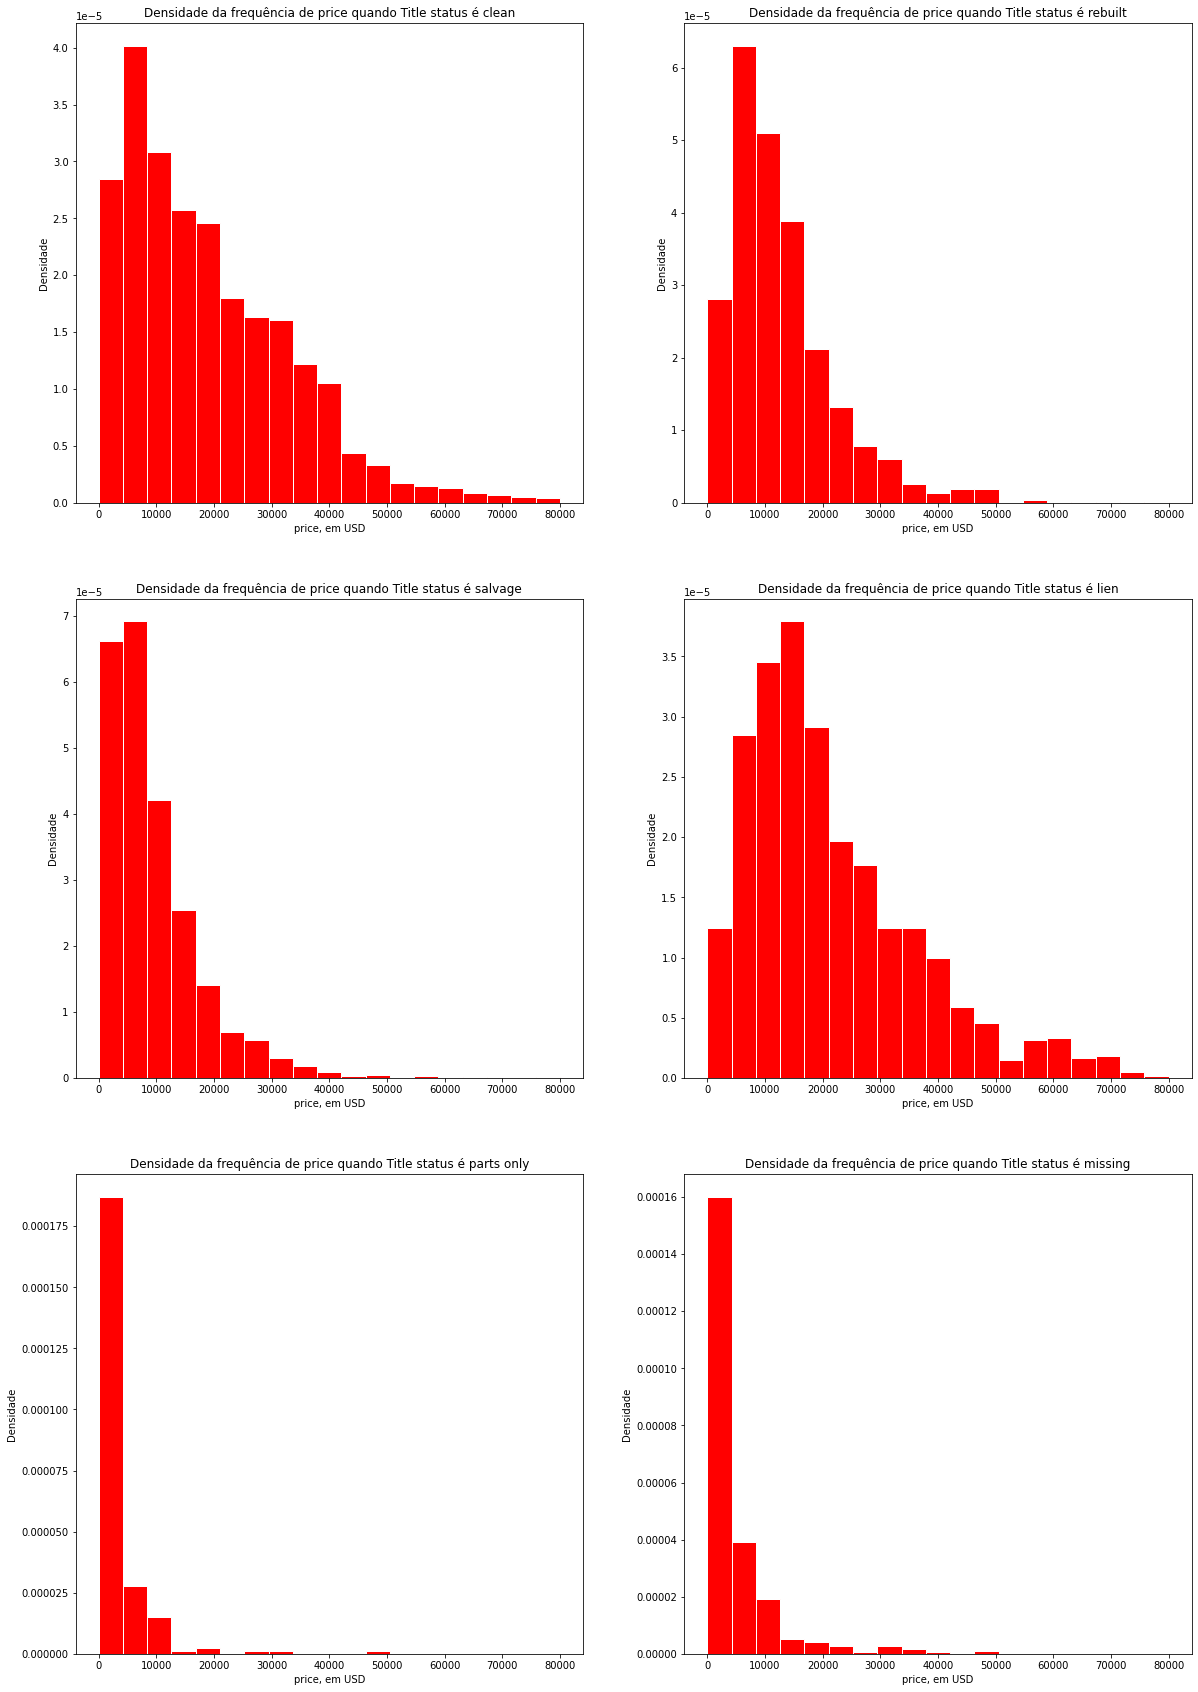

In [22]:
# Primeiramente, devemos decidir quais são as condições que o modelo assume. Imaginamos que venda de peças de carros
# ou de carros com peças faltando são casos significativamente diferentes do que a de um carro convencional. 

print(Dataset.title_status.value_counts(normalize=True))

# Para observar as diferenças:

PlotVariosHist(np.linspace(0,8e+4,20), 'price', 'USD', Dataset.title_status, 'Title status', ['clean', 'rebuilt', 'salvage', 'lien', 'parts only', 'missing'], 'red')

# Conclusão inicial:

Percebe-se que os preços de peças, carros com peça faltando e em más condições destoam bastante do convencional por praticamente não serem vendidos à valores mais altos. Já no caso de carros "com juros" (car lien é a venda de um carro em parcelas, na qual o vendedor cobra juros por segurança, podendo recuperar o carro caso não seja pago), eles costumam ter valores maiores que carros convencionais. Para carros reconstruídos, eles não cotumam ser vendidos por preços muito baixos, mas tendem a ter preços menores que o convencional na maioria dos casosetting an array element with a sequence.

A maioria dos carros convencionais são vendidos por preços abaixo de 20000 dólares e nota-se, portanto, que a densidade de veículos diminui com o aumento de preços.

count    393894.000000
mean      18902.138014
std       15398.367877
min           1.000000
25%        7000.000000
50%       15000.000000
75%       27590.000000
max      470000.000000
Name: price, dtype: float64


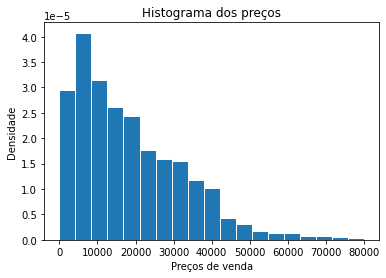

In [6]:
#Retirando preços excepcionais (nulos ou acima de 500000 dólares)
Dataset = Dataset.loc[Dataset['price'] > 0]
Dataset = Dataset.loc[Dataset['price'] < 0.5*(10**6)]

# Histograma de preços 

# Valores de interesse para basear as faixas
print(Dataset.price.describe())


plt.hist(Dataset.price,bins=np.linspace(0,8e+4,20),edgecolor='white',density=True)
plt.title('Histograma dos preços')
plt.xlabel('Preços de venda')
plt.ylabel('Densidade')
plt.show()

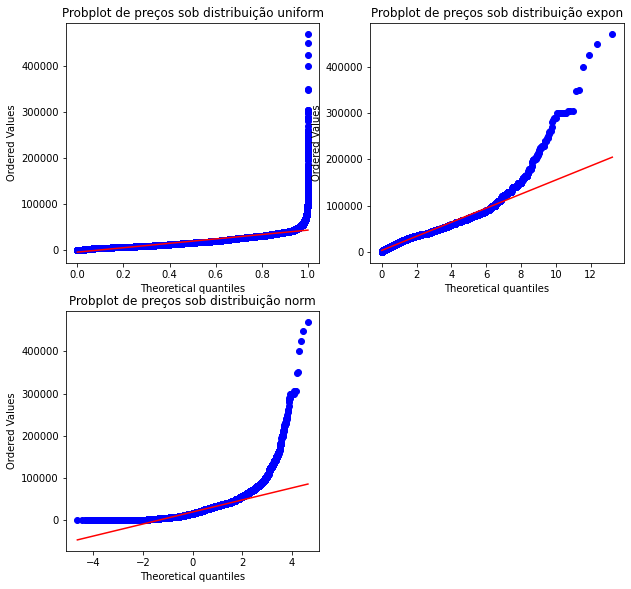

In [7]:
# A distribuição probabilística da variável target se assemelha, quase em sua totalidade com uma uniforme. 
# Para verificar temos que: 

distribuicoes = ['uniform', 'expon', 'norm']
plt.figure(figsize=(10,15))
for dist in distribuicoes:
    plt.subplot(321+distribuicoes.index(dist))
    stats.probplot(Dataset.price,dist=dist,plot=plt)
    plt.title("Probplot de preços sob distribuição {}".format(dist))
plt.show()

Correlação entre preço de carros e kilometragem: -0.16684091578146792


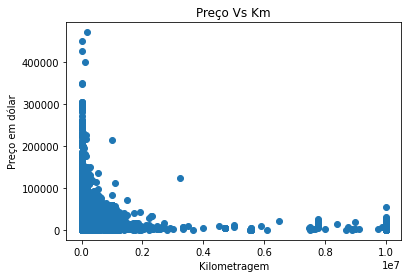

In [8]:
# Kilometragem e preço são relacionados?

print("Correlação entre preço de carros e kilometragem: {}".format(Dataset.price.corr(Dataset.odometer)))

plt.scatter(Dataset.odometer,Dataset.price)
plt.title('Preço Vs Km')
plt.ylabel('Preço em dólar')
plt.xlabel('Kilometragem')
plt.show()

# Correlação bem fraca e negativa

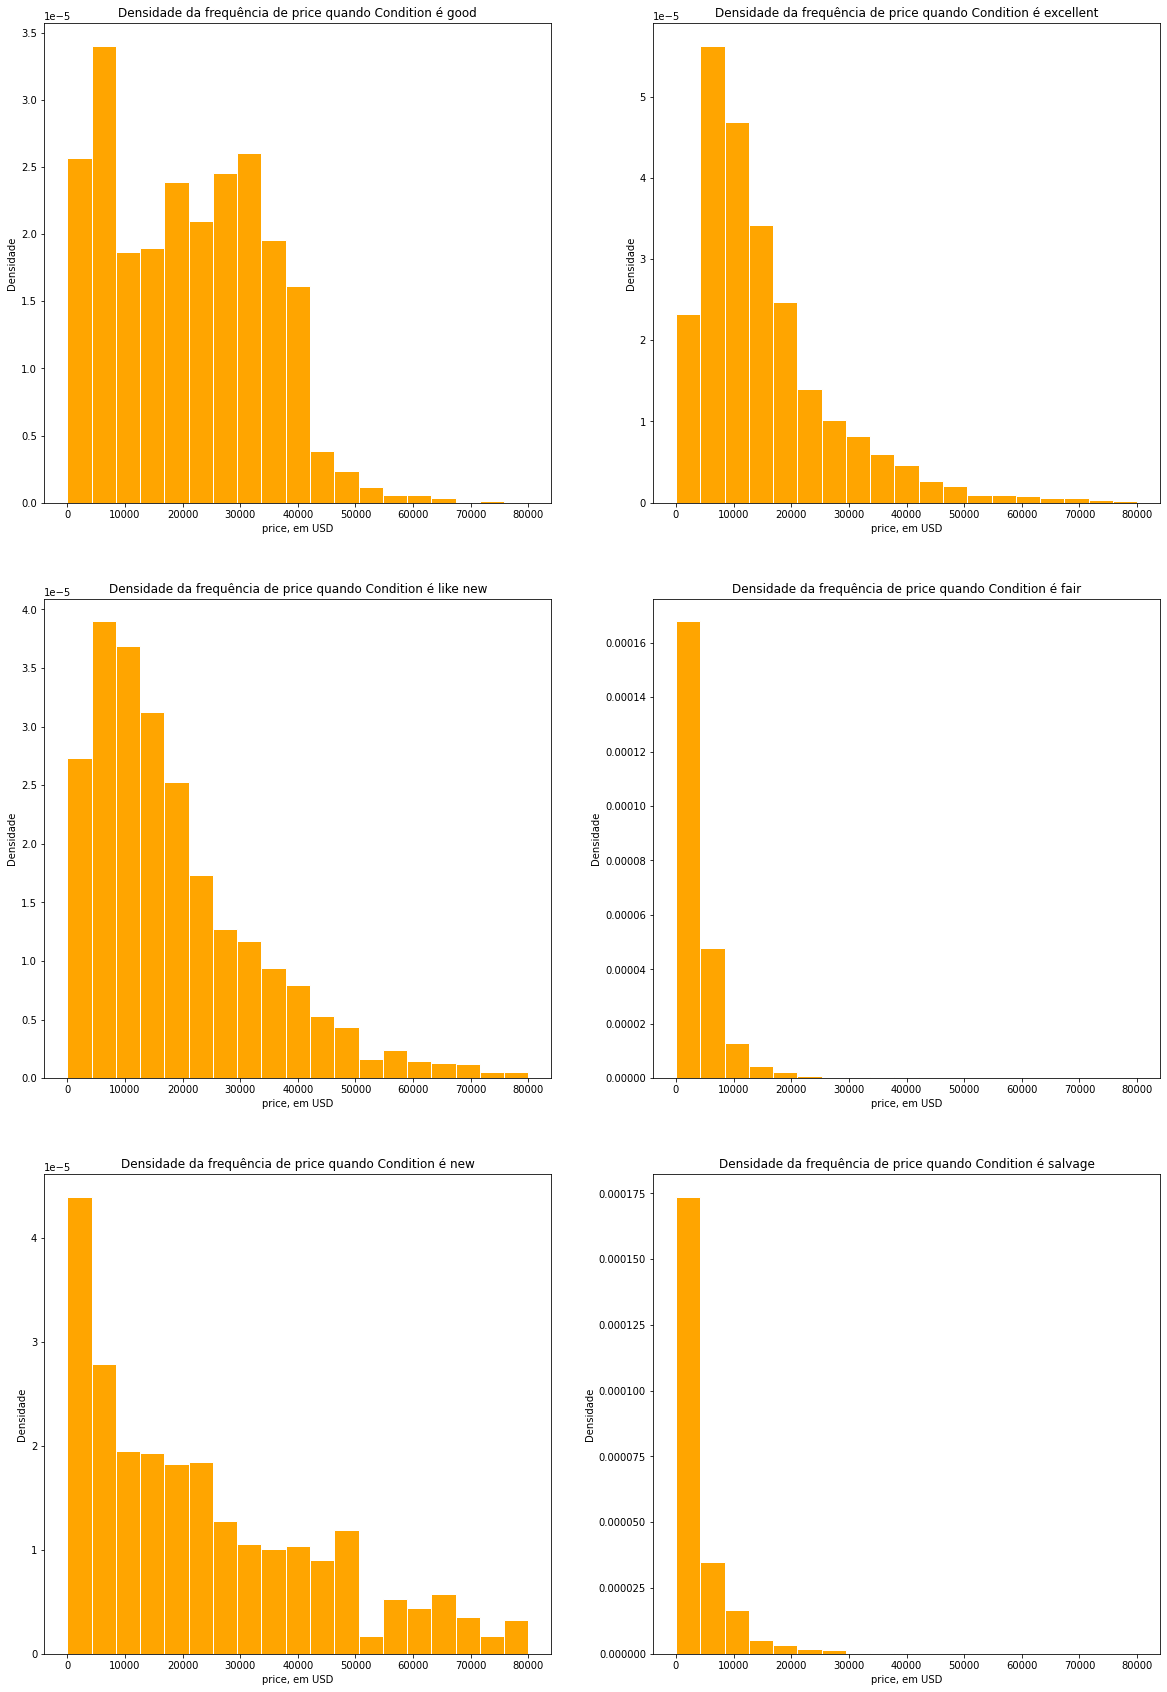

In [23]:
# Preço e condição se relacionam?

PlotVariosHist(np.linspace(0,8e+4,20), 'price', 'USD', Dataset.condition, 'Condition', ['good', 'excellent', 'like new', 'fair', 'new', 'salvage'], 'orange')


## Conclusão -  condição

No caso da condição boa nota-se uma distribuição mais homogênea de preços, exceto para valores mais altos.
Contraintuitivamente para condições excelentes há maiores densidades de preços de valores mais baixos do que para condições boas. Entretanto, para valores no outro extremo há maiores densidades de preços no caso da condição excelente.
Para condições novas as densidades de preço caem com o aumento dos valores de venda, mas ainda há maiores densidades para valores altos do que no caso de condições nova e excelente.
Olhando para as condições mediana e recuperado percebe-se que apresentam comportamento bastante semelhante de valores muito mais altos de densidades para preços (muito) baixos.
Finalmente, o comportamento dos preços da condição similar a novo assemelha-se ao da condição novo em relação à diminuição de densidade à medida que o preço aumenta. Entretanto, a condição similar a novo apresenta densidades significativamente maiores para preços médios e altos.

automatic    0.782386
other        0.156782
manual       0.060833
Name: transmission, dtype: float64


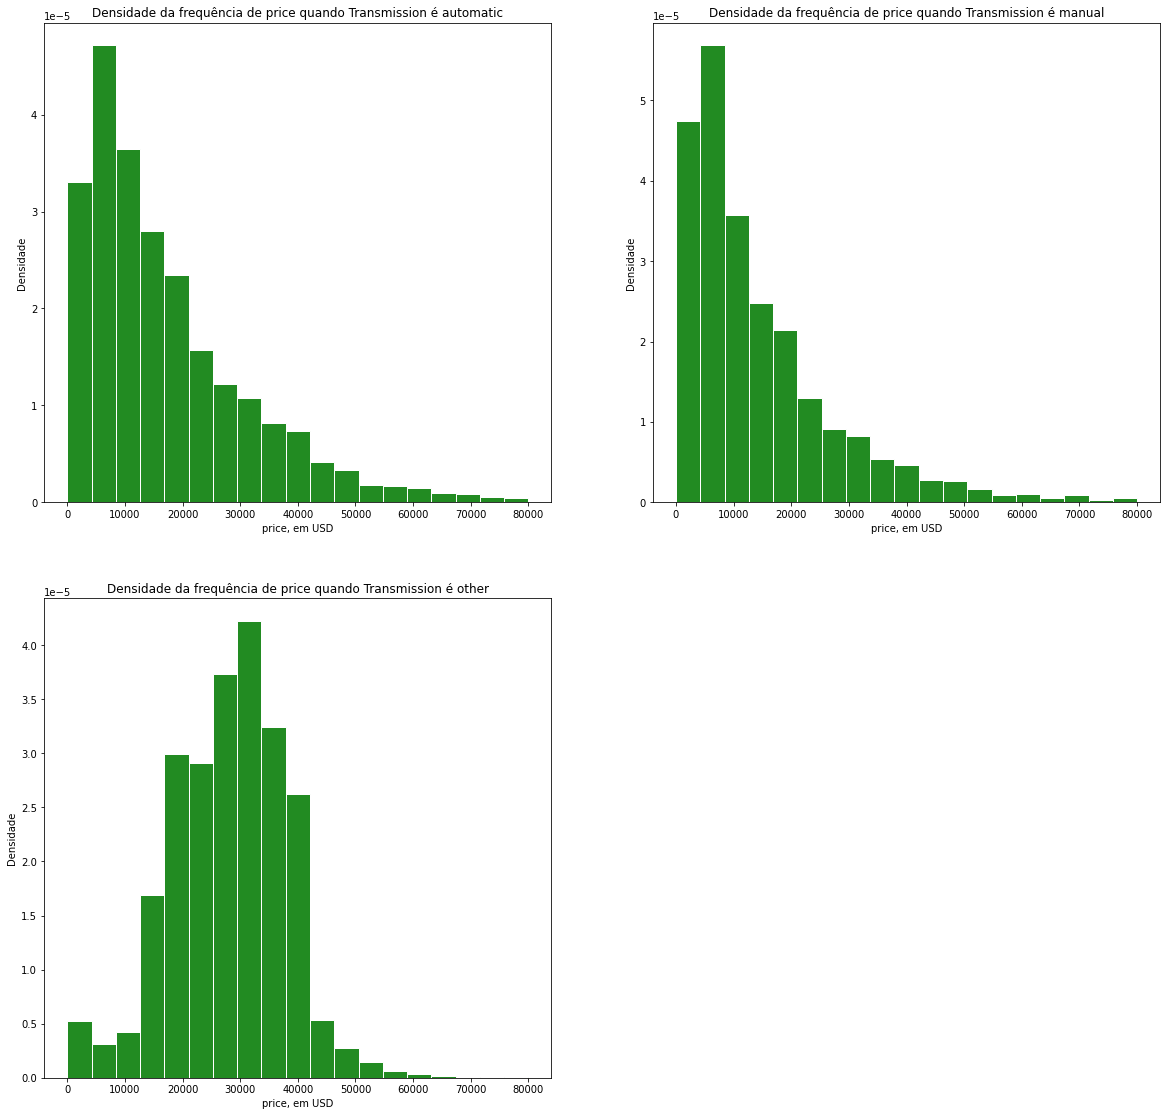

In [26]:
# Preço e tipo de câmbio se relacionam?

print(Dataset.transmission.value_counts(normalize=True))

PlotVariosHist(np.linspace(0,8e+4,20), 'price', 'USD', Dataset.transmission, 'Transmission', ['automatic', 'manual', 'other'], 'forestgreen')

# Percebe-se que carros automáticos e manuais tem uma distribuição relativamente parecida, diferentemente
# dos outros tipos, que destoam do padrão de preços.


## Conclusão - transmissão

A distribuição de preços de carros com câmbio automático e manual é bastante semelhante, no entanto, os automáticos apresentam densidades ligeiramente maiores em valores de venda mais altos.
No caso de outros tipos de transmissão, a distribuição de preços assemelha-se com uma distribuição normal, apresentando maiores densidades para valores medianos.

A correlação entre preço e ano, nos Dataset filtrados, é: 0.32395197948759713


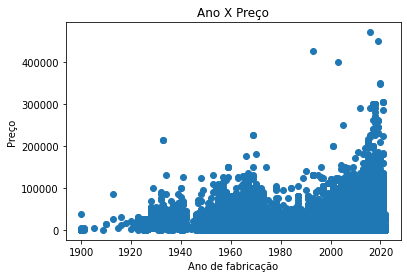

In [11]:
# Preço e ano de fabricação se relacionam?

print("A correlação entre preço e ano, nos Dataset filtrados, é: {}".format(Dataset.price.corr(Dataset.year)))
plt.scatter(Dataset.year,Dataset.price)
plt.xlabel('Ano de fabricação')
plt.ylabel('Preço')
plt.title('Ano X Preço')
plt.show()

# Associação fraca e positiva

## Variáveis dummy

Para trabalhar com modelos de regressão com variáveis quantitativas no target e qualitativas como features deve-se tratar as últimas como variáveis dummy. Isso significa que para cada uma das colunas de variáveis qualitativas serão criadas novas colunas para cada possível valor que a variável pode assumir. Caso uma linha apresente determinado valor, ela recebe '1' em sua respectiva coluna. Caso contrário, '0'.

Uma questão a ser considerada é a armadilha das variáveis dummies. Isso se refere à criação de variáveis de mais de uma coluna para valores que poderiam ser resumidos por uma só, a exemplo, 'sim' ou 'não'. Ser da categoria 'sim' implica em não ser da categoria 'não'. No caso, nossas categorias não possuem essa propriedade: ser da cor cinza não implica em ser da cor branca, uma vez que existem outras várias cores. Por isso não usamos a propriedade 'drop_first' para formar os dummies já que a perda da categoria inicial excluiria um perfil único por inteiro.

In [12]:
dum = pd.get_dummies(Dataset, drop_first=False, columns=['year', 'title_status', 'condition', 'transmission', 'cylinders', 'fuel', 'type', 'paint_color', 'manufacturer', 'drive', 'size'])

X = dum.iloc[:, 25:]

results = sm.OLS(dum.price, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.831
Model:                            OLS   Adj. R-squared (uncentered):              0.831
Method:                 Least Squares   F-statistic:                              9452.
Date:                Tue, 30 Nov 2021   Prob (F-statistic):                        0.00
Time:                        23:29:54   Log-Likelihood:                     -4.1875e+06
No. Observations:              393894   AIC:                                  8.375e+06
Df Residuals:                  393689   BIC:                                  8.378e+06
Df Model:                         205                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
year_1920.0                  -1.121e+04   7090.161     -1.581      0.114   -2.51e+04    2689.722
year_1921.0                  -9327.1795   7090.248     -1.315      0.188   -2.32e+04    4569.495
year_1922.0                  -6384.0052   5791.772     -1.102      0.270   -1.77e+04    4967.693
year_1923.0                  -5939.0885   1688.648     -3.517      0.000   -9248.788   -2629.389
year_1924.0                  -3763.8138   3351.924     -1.123      0.261   -1.03e+04    2805.857
year_1925.0                  -1.038e+04   3551.564     -2.922      0.003   -1.73e+04   -3416.237
year_1926.0                  -1.032e+04   2517.561     -4.098      0.000   -1.53e+04   -5383.391
year_1927.0                  -7014.1135   1688.332     -4.154      0.000   -1.03e+04   -3705.033
year_1928.0                   6576.3097   1688.139      3.896      0.000    3267.607    9885.012
year_1929.0                  -1155.4847   1361.859     -0.848      0.396   -3824.687    1513.718
year_1930.0                   2358.0142   1249.090      1.888      0.059     -90.165    4806.193
year_1931.0                    159.9068   1349.653      0.118      0.906   -2485.372    2805.186
year_1932.0                    1.11e+04   1386.144      8.007      0.000    8382.335    1.38e+04
year_1933.0                   2.667e+04   2018.930     13.209      0.000    2.27e+04    3.06e+04
year_1934.0                   1.192e+04   1532.069      7.781      0.000    8918.525    1.49e+04
year_1935.0                    946.7293   2104.704      0.450      0.653   -3178.427    5071.885
year_1936.0                    -88.6635   1547.083     -0.057      0.954   -3120.900    2943.573
year_1937.0                   6750.6074   1222.157      5.524      0.000    4355.216    9145.999
year_1938.0                  -1928.8577   1665.758     -1.158      0.247   -5193.693    1335.978
year_1939.0                   3949.3049   1481.764      2.665      0.008    1045.091    6853.518
year_1940.0                   5767.4548   1152.664      5.004      0.000    3508.268    8026.642
year_1941.0                  -3443.8292   1256.986     -2.740      0.006   -5907.483    -980.175
year_1942.0                    567.7844   2688.440      0.211      0.833   -4701.477    5837.045
year_1943.0                  -9144.6533      1e+04     -0.912      0.362   -2.88e+04    1.05e+04
year_1944.0                   -1.74e+04   5794.401     -3.003      0.003   -2.88e+04   -6044.878
year_1945.0                  -4700.7253   7090.863     -0.663      0.507   -1.86e+04    9197.154
year_1946.0                  -6330.0866   1349.391     -4.691      0.000   -8974.853   -3685.320
year_1947.0                  -2793.0591   1285.032     -2.174      0.030  

## Regressão linear

A regressão linear é um procedimento matemático que, dada uma série de valores, encontra a reta que melhor sintetiza o comportamento desses dados e que pode ser usada para extrapolar novos valores. O método de regressão utilizado foi o Método dos Mínimos Quadrados, que encontra a reta cuja diferença dos quadrados dos valores da série e da função é mínima.

O coeficiente de determinação (também chamado de R^2) mostra quanto os valores da reta aproximam-se da realidade, sendo que quanto mais próximo de 1, mais fidedigno é o resultado.

Em nosso caso, o valor desse coeficiente (R-squared) = 0.831, o que indica que é significativamente próximo à realidade.

In [13]:
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(X, dum.price)
score = regressor.score(X, dum.price)
score

0.9291317657074678

## Regressão de árvore de decisão

Árvores de decisão são um método que tem como objetivo criar um modelo para prever o valor de uma variável target ao aprender regras de decisão da série de dados das features. No caso da biblioteca utilizada o regeressor monta a melhor curva seno possível para aproximar uma regra no modelo if/else. Com quanto mais variáveis features (justificadas) o modelo for alimentado, maior será o número de ramificações, que aumentará a complexidade das regras e tornará o modelo mais confiável.

Bem como na regressão linear, deverão ser utilizadas variáveis dummy para trabalhar quantitativamente com variáveis qualitativas.

Um dos pontos negativos do uso de árvores de decisão é o overfitting, isto é, a alimentação de input irrelevante ou pouco diverso para a classificação, que pode tornar o resultado um simulacro da realidade. Por isso, deve-se ter cuidado com a alimentação de dados do modelo. Entretanto, em casos com uso de variáveis categóricas independentes e bases de dados com bastante ruído e grande número de amostras, árvores de decisão entregam melhores resultados que regressões lineares.

In [14]:
#ano title_status condition transmission cylinders fuel type paint_color manufacturer drive size

def predictor(year, title_status, condition, transmission, cylinders, fuel, body_type, paint_color, manufacturer, drive, size):
    
    lista = []
    ano_checado = False
    status_checado = False
    condicao_checado = False
    transmissao_checado = False
    cilindros_checado = False
    combustivel_checado = False
    tipo_checado = False
    tinta_checado = False
    montadora_checado = False
    tracao_checado = False
    tamanho_checado = False


    
    for ano in X.columns[:103]:
        if year in ano:
            lista.append(1)
            ano_checado = True
        else:
            lista.append(0)
    
    
    for status in X.columns[103:109]:
        if title_status in status:
            lista.append(1)
            status_checado = True
        else:
            lista.append(0)
    
    for condicao in X.columns[109:115]:
        if condition in condicao:
            lista.append(1)
            condicao_checado = True
        else:
            lista.append(0)
            
    for transmissao in X.columns[115:118]:
        if transmission in transmissao:
            lista.append(1)
            transmissao_checado = True
        else:
            lista.append(0)
            
    for cilindros in X.columns[118:126]:
        if cylinders in cilindros:
            lista.append(1)
            cilindros_checado = True
        else:
            lista.append(0)
            
    for combustivel in X.columns[126:131]:
        if fuel in combustivel:
            lista.append(1)
            combustivel_checado = True
        else:
            lista.append(0)
            
    for tipo in X.columns[131:144]:
        if body_type == 'van' and tipo == 'type_van':
            lista.append(1)
            tipo_checado = True
        elif body_type in tipo:
            lista.append(1)
            tipo_checado = True
        else:
            lista.append(0)
            
    for tinta in X.columns[144:156]:
        if paint_color in tinta:
            lista.append(1)
            tinta_checado = True
        else:
            lista.append(0)
    
    for montadora in X.columns[156:199]:
        if manufacturer in montadora:
            lista.append(1)
            montadora_checado = True
        else:
            lista.append(0)
    
    for tracao in X.columns[199:201]:
        if drive in tracao:
            lista.append(1)
            tracao_checado = True
        else:
            lista.append(0)
    
    for tamanho in X.columns[201:]:
        if size == 'compact' and tamanho == 'size_compact':
            lista.append(1)
            tamanho_checado = True
        elif size in tamanho:
            lista.append(1)
            tamanho_checado = True
        else:
            lista.append(0)
    
    print([ano_checado, status_checado, condicao_checado, transmissao_checado, cilindros_checado, combustivel_checado, tipo_checado, tinta_checado, montadora_checado, tracao_checado, tamanho_checado])
    
    if any([ano_checado, status_checado, condicao_checado, transmissao_checado, cilindros_checado, combustivel_checado, tipo_checado, tinta_checado, montadora_checado, tracao_checado, tamanho_checado])==False:
        return ('input invalido')
            
    return regressor.predict([lista]), results.predict(lista)
    


## Ressalva

Para a realização do modelo, foram desconsiderados variáveis extraordinárias que não estavam contidas no Dataset. Portanto, em casos como na tração, em que se existe mais tipos do que as consideradas no Dataset, foi realizada uma simplificação para limitar o input do usuário. Caso algum valor não exista, será retornado "input invalido". 

In [15]:
#Testando para um valor específico

teste_tree, teste_linear = predictor('2020', 'clean', 'fair', 'manual', '8', 'gas', 'sedan', 'black', 'volkswagen', 'fwd', 'compact')

print(teste_tree, teste_linear)

[True, True, True, True, True, True, True, True, True, True, True]
[103000.] [26634.87551096]


In [17]:
# Validação cruzada
z=0
a=0
for linha in dum.sample(100).values:
    preco = linha[4]
    filtrado = linha[25:]
    reg_tree = regressor.predict([filtrado])
    reg_linear = results.predict(filtrado)
    #print(f'Preço real: {preco}. Preço calculado pela regressão linear: {reg_linear}. Preço calculado pela regressão de árvore de decisão: {reg_tree}.')
    diferenca_tree= abs(preco-reg_tree)
    if diferenca_tree <= preco*0.1:
        z+=1
    diferenca_linear= abs(preco-reg_linear)
    if diferenca_linear <= preco*0.1:
        a+=1
print(f'A porcentagem da diferença entre o preço real e o calculado pela regressão de árvore de decisão para 100 amostras foi de {z} %')
print(f'A porcentagem da diferença entre o preço real e o calculado pela regressão linear para 100 amostras foi de {a} %')


    
    

A porcentagem da diferença entre o preço real e o calculado pela regressão de árvore de decisão para 100 amostras foi de 81 %
A porcentagem da diferença entre o preço real e o calculado pela regressão linear para 100 amostras foi de 16 %


In [18]:
# Extrapolando o passo anterior para encontrar as médias das porcentagens contendo o maior número de amostras

def teste(n):
    lista_a=[]
    lista_z=[]
    for e in range(n):
        a=0
        z=0
        for linha in dum.sample(100).values:
            preco = linha[4]
            filtrado = linha[25:]
            reg_tree = regressor.predict([filtrado])
            reg_linear = results.predict(filtrado)
            diferenca_tree= abs(preco-reg_tree)
            if diferenca_tree <= preco*0.1:
                z+=1
            diferenca_linear= abs(preco-reg_linear)
            if diferenca_linear <= preco*0.1:
                a+=1
        lista_a.append(a)
        lista_z.append(z)
    media_a=sum(lista_a)/len(lista_a)
    media_z=sum(lista_z)/len(lista_z)
    std_a=pd.Series(lista_a).std()
    std_z=pd.Series(lista_z).std()
    print(f' A Média do teste para a regressão linear é de {media_a} %')   
    print(f' A Média do teste para a regressão de árvore de decisão é de {media_z} %')
    print(f' O Desvio Padrão do teste para a regressão linear é de {std_a:.3f}') 
    print(f' O Desvio Padrão do teste para a regressão de árvore de decisão é de {std_z:.3f}') 
    return lista_a,lista_z
teste(1000);  

 A Média do teste para a regressão linear é de 20.687 %
 A Média do teste para a regressão de árvore de decisão é de 77.97 %
 O Desvio Padrão do teste para a regressão linear é de 4.117
 O Desvio Padrão do teste para a regressão de árvore de decisão é de 4.067


 A Média do teste para a regressão linear é de 20.405 %
 A Média do teste para a regressão de árvore de decisão é de 78.09 %
 O Desvio Padrão do teste para a regressão linear é de 3.983
 O Desvio Padrão do teste para a regressão de árvore de decisão é de 4.133


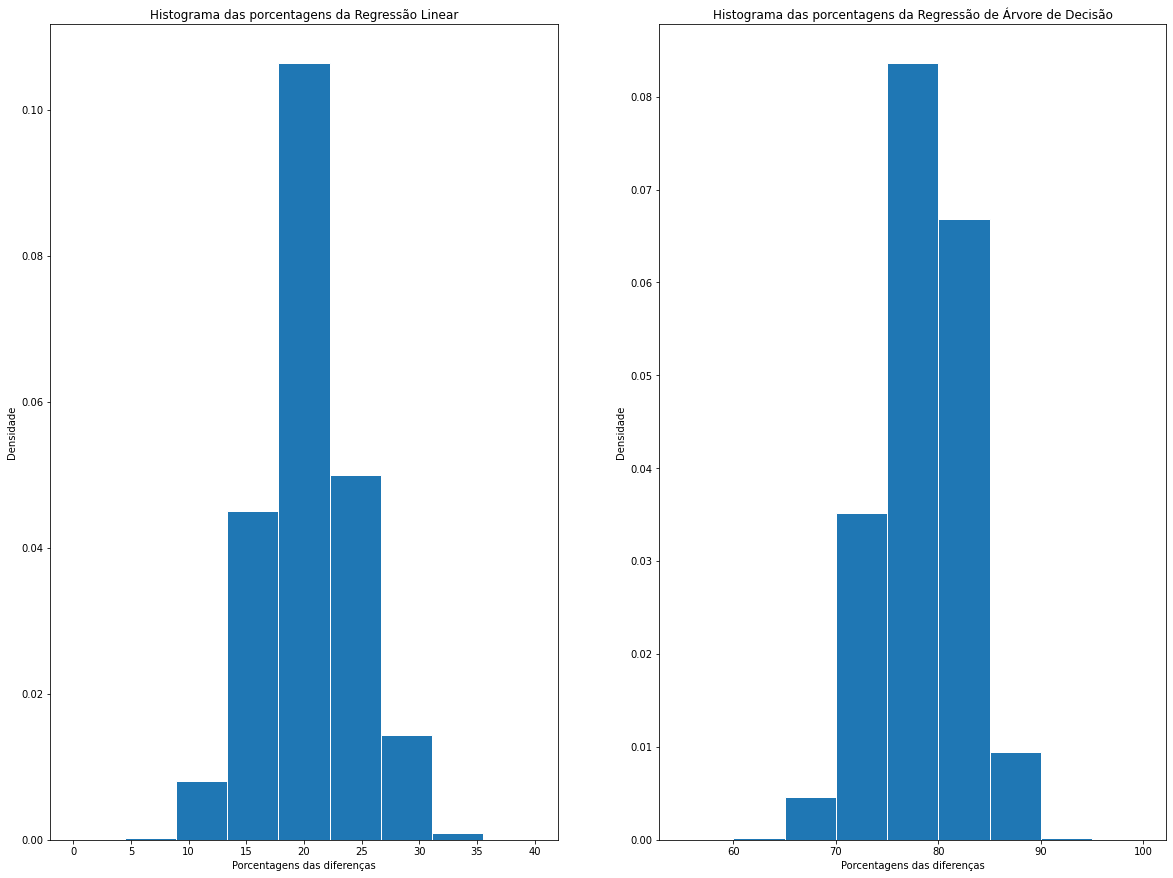

In [19]:
#Histograma para as porcentagens da regressão linear e da regressão da árvore de decisão
valores_linear,valores_tree=teste(1000)

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.hist(valores_linear,bins=np.linspace(0,40,10),edgecolor='white',density=True)
plt.xlabel('Porcentagens das diferenças')
plt.ylabel('Densidade')
plt.title('Histograma das porcentagens da Regressão Linear')
plt.subplot(1,2,2)
plt.hist(valores_tree,bins=np.linspace(55,100,10),edgecolor='white',density=True)
plt.xlabel('Porcentagens das diferenças')
plt.ylabel('Densidade')
plt.title('Histograma das porcentagens da Regressão de Árvore de Decisão')
plt.show()

In [20]:
#Retirando informações relevantes
print(pd.Series(valores_linear).describe())
print(pd.Series(valores_tree).describe())

count    1000.000000
mean       20.405000
std         3.983069
min         8.000000
25%        18.000000
50%        20.000000
75%        23.000000
max        33.000000
dtype: float64
count    1000.000000
mean       78.090000
std         4.132914
min        64.000000
25%        75.000000
50%        78.000000
75%        81.000000
max        90.000000
dtype: float64


## Referências

https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html

https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222

https://stackoverflow.com/questions/17614467/how-can-unrar-a-file-with-python

https://www.kaggle.com/austinreese/craigslist-carstrucks-data/tasks

## Conclusões

Tendo feito a validação cruzada e uma análise percentual entre os tipos de regressão, é importante ressaltar que a regressão linear não conseguiu prever valores para os carros perto dos preços originais, em função da baixa porcentagem de diferença. No entanto, a regressão de árvore de decisão gerou resultados satisfatórios, em função da diferença percentual. Isso era esperado, uma vez que o coeficiente de determinação (r quadrado) da regressão de árvore de decisão é maior do que da regressão linear.


    